# Stock Market Analysis
Historical daily prices of all stocks and ETFs

## Problem Statement:

To predict daily closing price of the selected stock using different algorithms of machine learning.

Broadly, stock market analysis can divided into two parts – Fundamental Analysis and Technical Analysis.

* <b>Fundamental Analysis</b>: analyzing  company’s future profitability on the basis of its current business environment and financial performance.
\n
* <b>Technical Analysis</b>: reading the charts and using statistical figures to identify the trends in the stock market.

In addition to these analysis, please note that Stock Price is also affected by the news about the company and other factors like demonetization or merger/demerger of the companies. There are certain intangible factors as well which can often be impossible to predict beforehand.

## Dataset:

Variables in the dataset:

* <b> Date </b>: the date at which the stock is traded.
* <b> Open </b>: the staring price at which the stock is traded on a particular day.
* <b> High </b>: the maximum price of the share for the day.
* <b> Low </b>: the minimum price of the share for the day
* <b> Last </b>: the last price of the share for the day.
* <b> Close </b>: the final price at which the stock is traded on a particular day.
* <b> Total Trade Quantity </b>: the number of shares bought or sold for the day.
* <b> Turnover </b>: the amount of money taken by the particular company on a a given date.

Note: the market is closed on weekends and public holidays.Notice the above table again, some date values are missing – 2/10/2018, 6/10/2018, 7/10/2018. Of these dates, 2nd is a national holiday while 6th and 7th fall on a weekend.

### Import libraries and define setting

In [28]:
# import required libraries 
import pandas as pd
import numpy as np
from fastai.tabular import add_datepart
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
from pmdarima import auto_arima
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
#from fbprophet import Prophet
#import pystan

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# to ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

### Import data then perform EDA

In [2]:
# read and inspect the file
df = pd.read_csv('NSE-TATAGLOBAL11.csv')

# print the head
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the <b> closing price as the target variable </b>. Let’s plot the target variable to understand how it’s shaping up in our data:

Text(0.5, 1.0, 'Close Price history')

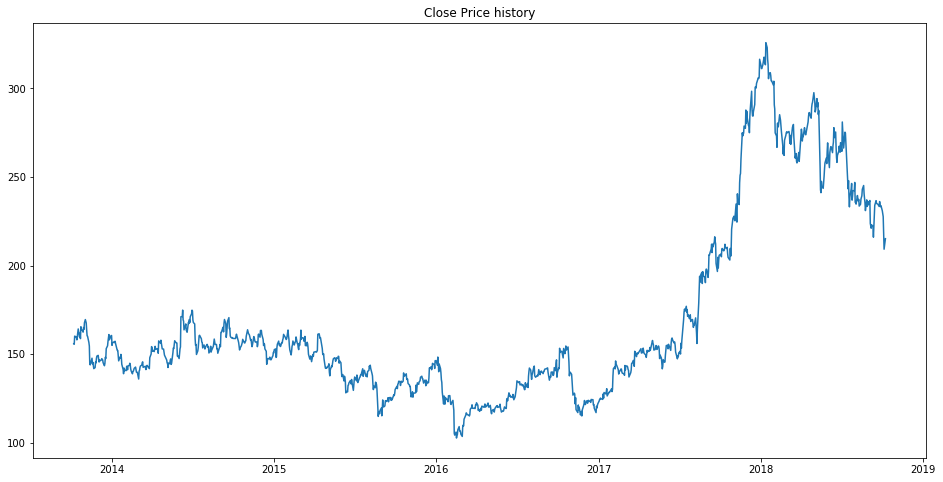

In [3]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'])
plt.title('Close Price history')

### Data Pre-processing: create a dataframe that contains only Date and Close variables

Sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data. 

In [5]:
# creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Close'][i] = data['Close'][i]

new_data.head(5)

,Date,Close
0,2013-10-08 00:00:00,155.8
1,2013-10-09 00:00:00,155.55
2,2013-10-10 00:00:00,160.15
3,2013-10-11 00:00:00,160.05
4,2013-10-14 00:00:00,159.45


## Option A: Moving Average

The predicted closing price for each day will be the average of a set of previously observed values. Instead of using the simple average, we will be using the <b> moving average technique </b> which uses the latest set of values for each prediction. In other words, for each subsequent step, the predicted values are taken into consideration while removing the oldest observed value from the set.

### Split dataframe into train and validation sets

NOTE: While splitting the data into train and validation set, do not use random splitting since that will destroy the time component. So here we have set the last year’s data into validation and the 4 years’ data before that into train set.

In [6]:
print('\n Shape of the data:', df.shape)

# splitting into train and validation (80:20)
train = new_data[:987]
valid = new_data[987:]

# shapes of training set
print('\n Shape of training set:', train.shape)

# shapes of validation set
print('\n Shape of validation set:', valid.shape)


 Shape of the data: (1235, 8)

 Shape of training set: (987, 2)

 Shape of validation set: (248, 2)


### Create predictions for the validation set and check the RMSE using the actual values

In [12]:
# making predictions
preds = []
for i in range(0, valid.shape[0]):
    a = train['Close'][len(train)-valid.shape[0]+i:].sum() + sum(preds)
    b = a/valid.shape[0]
    preds.append(b)

# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
print('\n RMSE value on validation set:', rms)


 RMSE value on validation set: 104.51415465984348


### Plot to visualize actual vs. predicted values

Text(0.5, 1.0, 'Prediction using Moving Average')

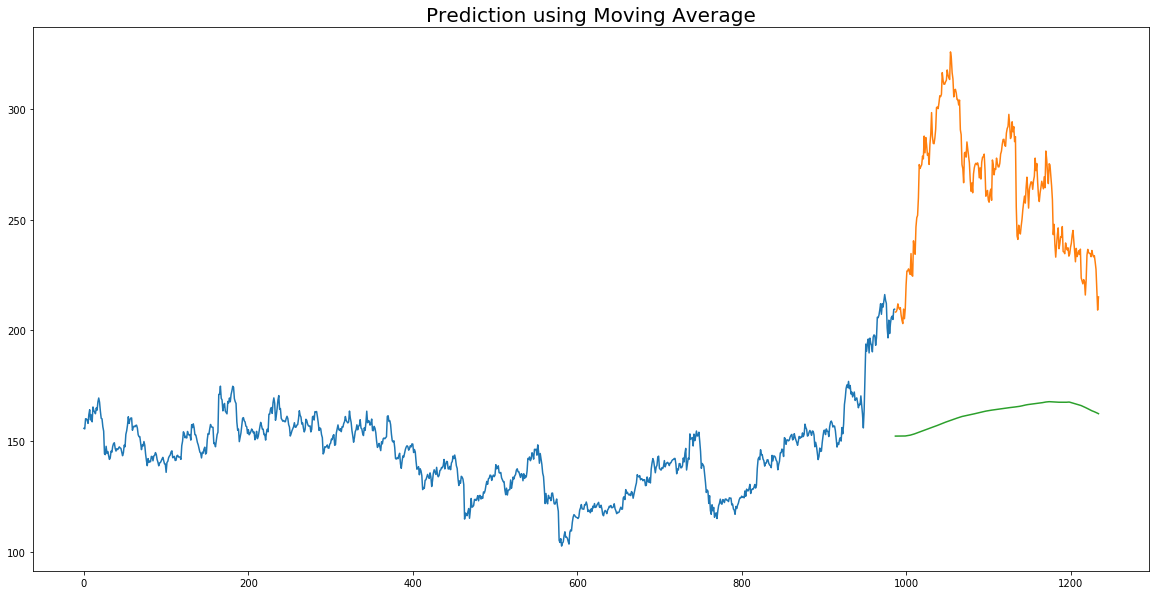

In [15]:
valid['Predictions'] = 0
valid['Predictions'] = preds

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.title('Prediction using Moving Average', fontsize=20)

### Inference

The RMSE value is close to 105 but the results are not very promising. The predicted values are of the same range as the observed values in the train set (there is an increasing trend initially and then a slow decrease).

## Option B: Linear Regression

"Some explanation on LR"

### Create features that might be relevant to predictions 

From data created in section 2.3, create new features using *add_datepart()* from *fastai* library:

* Year
* Month
* Week
* Day
* Dayofweek
* Dayofyear
* is_month_end
* is_month_start
* is_quarter_end
* is_quarter_start
* is_year_end
* is_year_start

In [9]:
# create features
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp
new_data.head(5)

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,155.8,2013,10,41,8,1,281,False,False,False,False,False,False
1,155.55,2013,10,41,9,2,282,False,False,False,False,False,False
2,160.15,2013,10,41,10,3,283,False,False,False,False,False,False
3,160.05,2013,10,41,11,4,284,False,False,False,False,False,False
4,159.45,2013,10,42,14,0,287,False,False,False,False,False,False


### Split the data into train and validation sets

In [10]:
# split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

### Fit LR model and check model performance

In [16]:
# implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

# make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print('\n RMSE value on validation set:', rms)


 RMSE value on validation set: 121.16382449873923


### Plot to visualize actual vs. predicted values

Text(0.5, 1.0, 'Prediction using Linear Regression')

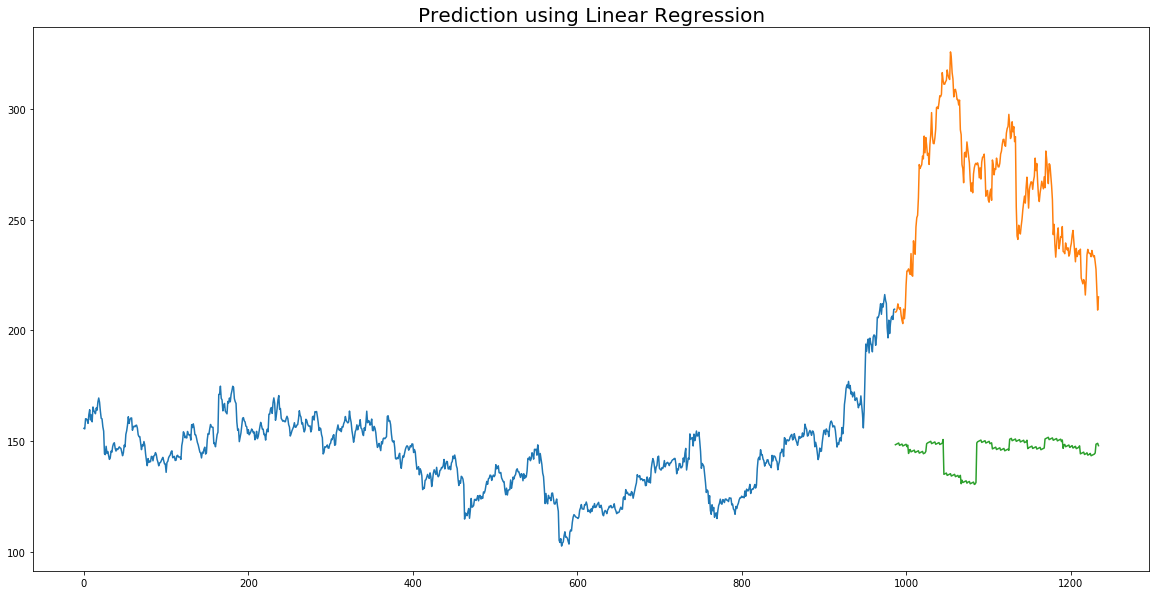

In [17]:
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[987:].index
train.index = new_data[:987].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.title('Prediction using Linear Regression', fontsize=20)

### Inference

The RMSE value is higher hence the results are worse than Option A. The model overfits to the date and month column. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago, or the same date/month a year ago.

LR technique can perform well when the independent features are useful in determining the target value (in this case we only have target value).

## Option C: k-Nearest Neighbours (kNN)

kNN finds the similarity between new data points and old data points based on the values of independent variables.

### Fit kNN model onto the same train and validation set from section 4.2 and check model performance


In [18]:
# scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

# using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

# fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

# calculate rmse
rms = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print('\n RMSE value on validation set:', rms)


 RMSE value on validation set: 114.820692914522


### Plot to visualize actual vs. predicted values

Text(0.5, 1.0, 'Prediction using k-Nearest Neighbours')

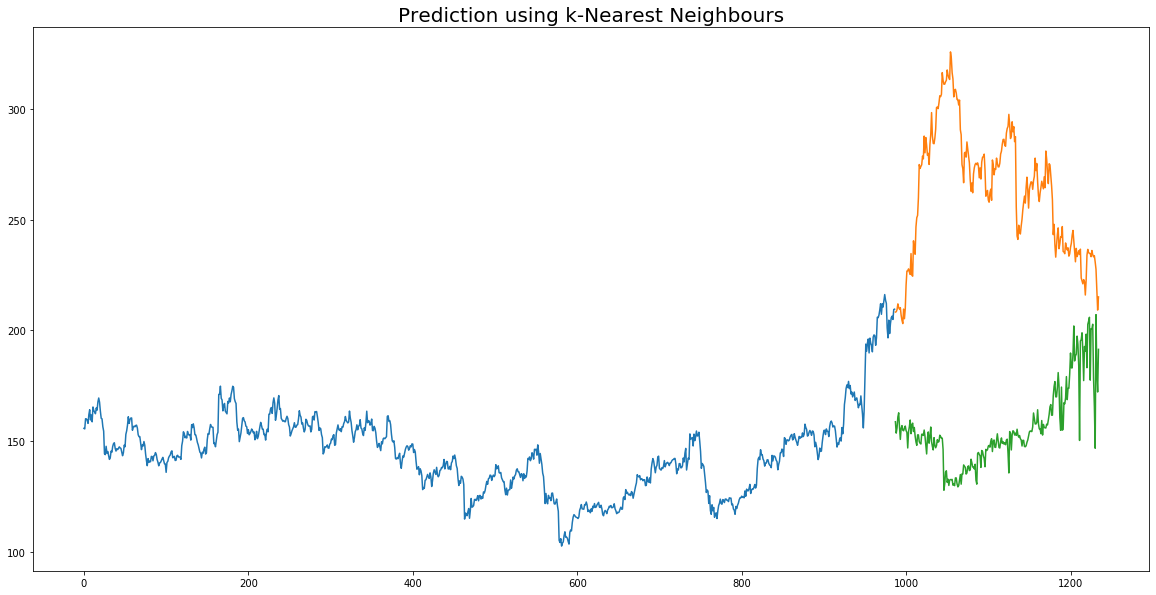

In [19]:
valid['Predictions'] = 0
valid['Predictions'] = preds

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.title('Prediction using k-Nearest Neighbours', fontsize=20)

### Inference

The RMSE value is almost similar to the linear regression model and the plot shows the same pattern. Like linear regression, kNN also identified a drop in January 2018 since that has been the pattern for the past years. In conclusion, regression algorithms have not performed well on this dataset. 

## Option D: Auto ARIMA

ARIMA is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

* <b> p </b>: past values used for forecasting the next value)
* <b> q </b>: past forecast errors used to predict the future values)
* <b> d </b>: order of differencing)

Auto ARIMA automatically selects the best combination of (p,q,d) that provides the least error - which is better than parameter tuning in ARIMA as it consumes a lot of time.

### Split the data into train and validation sets - fit the model - check model performance - plot the result

In [21]:
train = data[:987]
valid = data[987:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=248)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=4820.561, BIC=4844.968, Time=17.205 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=5479.245, BIC=5489.008, Time=0.146 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=5170.275, BIC=5189.801, Time=2.850 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=4818.530, BIC=4838.055, Time=9.744 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=5477.259, BIC=5482.140, Time=0.100 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=5483.137, BIC=5502.663, Time=1.739 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=4817.378, BIC=4846.666, Time=20.647 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse

In [22]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
print('\n RMSE value on validation set:', rms)


 RMSE value on validation set: 44.94077140334862


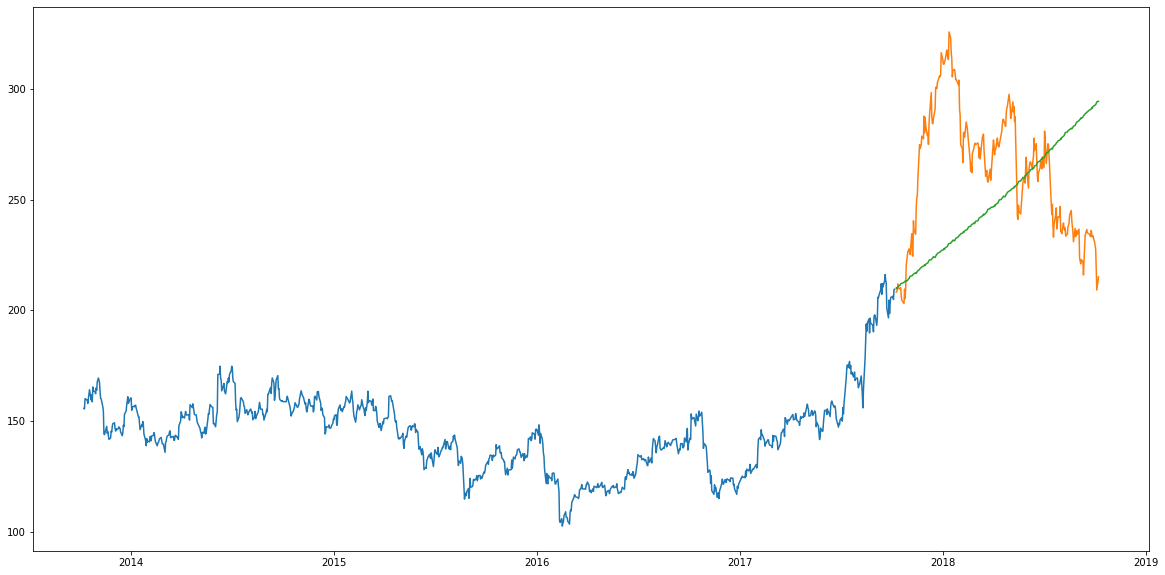

In [23]:
# plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

### Inference

An auto ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. Although the predictions using this technique are far better than that of the previously implemented machine learning models, these predictions are still not close to the real values.

As its evident from the plot, the model has captured a trend in the series, but does not focus on the seasonal part. In the next section, we will implement a time series model that takes both trend and seasonality of a series into account.

## Long Short Term Memory (LSTM)

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. LSTM has three gates:

* <b> The input gate </b>: The input gate adds information to the cell state
* <b> The forget gate </b>: It removes the information that is no longer required by the model
* <b> The output gate </b>: Output Gate at LSTM selects the information to be shown as output

In [24]:
# creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

# setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

# creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

# converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

# predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

W0326 07:43:46.216524 18532 deprecation_wrapper.py:119] From C:\Users\norzarifah.k\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0326 07:43:46.308965 18532 deprecation_wrapper.py:119] From C:\Users\norzarifah.k\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0326 07:43:46.333854 18532 deprecation_wrapper.py:119] From C:\Users\norzarifah.k\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0326 07:43:47.411214 18532 deprecation_wrapper.py:119] From C:\Users\norzarifah.k\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer i

Epoch 1/1
 - 80s - loss: 0.0010


In [25]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print('\n RMSE value on validation set:', rms)


 RMSE value on validation set: 13.969400843464602


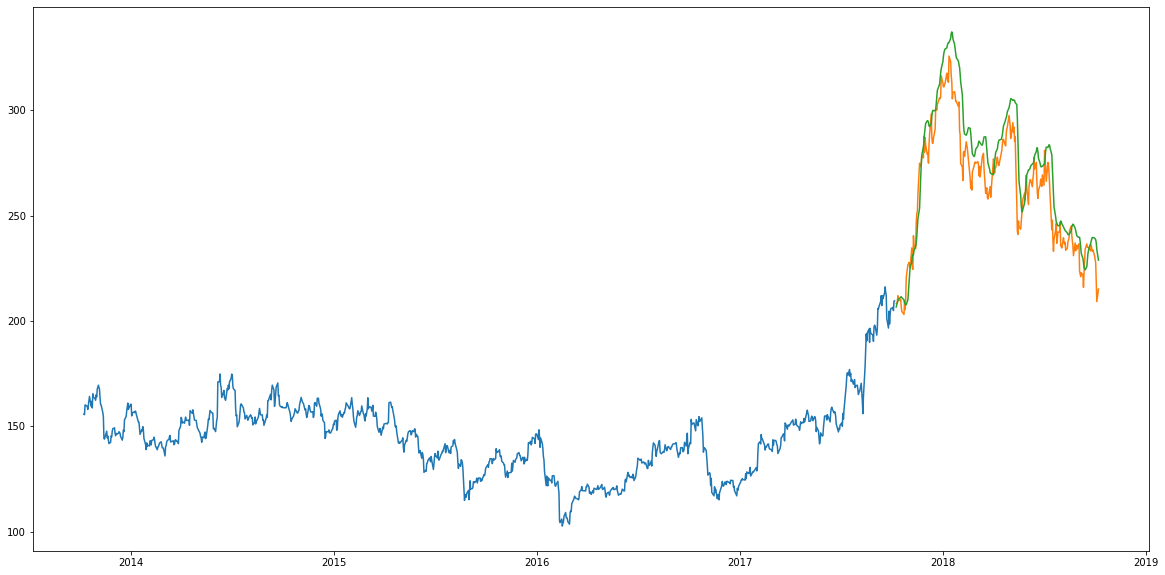

In [26]:
# plot results
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

### Inference

The LSTM model performed better than the rest. It can be tuned for various parameters such as changing the number of LSTM layers, adding dropout value or increasing the number of epochs. 

## Option E: Prophet

There are a number of time series techniques that can be implemented on the stock prediction dataset, but most of these techniques require a lot of data preprocessing before fitting the model. Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframe with two columns: date and target (ds and y).

Prophet tries to capture the seasonality in the past data and works well when the dataset is large.

In [29]:
# # creating dataframe
# new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

# for i in range(0,len(data)):
#     new_data['Date'][i] = data['Date'][i]
#     new_data['Close'][i] = data['Close'][i]

# new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
# new_data.index = new_data['Date']

# # preparing data
# new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

# # train and validation
# train = new_data[:987]
# valid = new_data[987:]

# # fit the model
# model = Prophet()
# model.fit(train)

# # predictions
# close_prices = model.make_future_dataframe(periods=len(valid))
# forecast = model.predict(close_prices)